# Preliminary

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, GRU, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns




In [2]:
df = pd.read_csv('data/player_stats.csv')
df = df.sort_values(by=['player_id', 'season', 'week'])


# EDA

In [3]:
df.dtypes 



player_id                       object
player_name                     object
player_display_name             object
position                        object
position_group                  object
headshot_url                    object
recent_team                     object
season                           int64
week                             int64
season_type                     object
opponent_team                   object
completions                      int64
attempts                         int64
passing_yards                    int64
passing_tds                      int64
interceptions                    int64
sacks                            int64
sack_yards                       int64
sack_fumbles                     int64
sack_fumbles_lost                int64
passing_air_yards                int64
passing_yards_after_catch        int64
passing_first_downs              int64
passing_epa                    float64
passing_2pt_conversions          int64
pacr                     

In [4]:
df

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr,years_in_league,years_played
0,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,1,REG,...,0,0.000000,0.052632,NaN,NaN,0,12.7,13.7,1.0,0
1,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,2,REG,...,0,0.000000,0.117647,NaN,NaN,0,5.1,8.1,1.0,0
2,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,MIA,1999,4,REG,...,0,NaN,0.023810,NaN,NaN,0,0.2,0.2,1.0,0
3,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,CLE,1999,7,REG,...,0,0.000000,0.050000,NaN,NaN,0,3.5,5.5,1.0,0
4,00-0000003,NaN,Abdul-Karim al-Jabbar,RB,RB,NaN,CLE,1999,8,REG,...,0,NaN,NaN,NaN,NaN,0,3.9,3.9,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128868,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,14,REG,...,0,-0.666667,0.032258,-0.025532,0.030515,0,4.8,5.8,1.0,0
128869,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,15,REG,...,0,0.000000,0.031250,0.012658,0.055736,0,1.6,1.6,1.0,0
128870,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,16,REG,...,0,0.307692,0.055556,-0.056034,0.044109,0,-0.4,0.6,1.0,0
128871,00-0039165,Z.Charbonnet,Zach Charbonnet,RB,RB,https://static.www.nfl.com/image/private/f_aut...,SEA,2023,17,REG,...,0,3.000000,0.151515,0.057778,0.267717,0,4.1,9.1,1.0,0


In [5]:
df.isnull().sum(axis=0)

player_id                           0
player_name                     67380
player_display_name                 3
position                           72
position_group                     72
headshot_url                    59092
recent_team                         0
season                              0
week                                0
season_type                         0
opponent_team                       0
completions                         0
attempts                            0
passing_yards                       0
passing_tds                         0
interceptions                       0
sacks                               0
sack_yards                          0
sack_fumbles                        0
sack_fumbles_lost                   0
passing_air_yards                   0
passing_yards_after_catch           0
passing_first_downs                 0
passing_epa                    112406
passing_2pt_conversions             0
pacr                           112846
dakota      

# Feature Engineering


- Trend analysis
- Week-to-week consistency/variability
    - standard deviation of weekly totals
- Rolling averages of last n weeks/years
- Years in league = season - player's first season

In [6]:
# Rolling averages of last n years

# Years in league
# for each unique player id, get the number of years they have been in the league
# Years in league
df['years_played'] = df.groupby('player_id')['season'].rank(method='dense')-1
df['years_played'] = df['years_played'].astype(int)

# Data cleaning

In [7]:
# Drop any rows with season="POST"
df = df[df['season_type'] != 'POST']

# Full df cleaning
df.drop(
    columns=[
        'headshot_url',
        'player_name',
        'player_display_name',
        'recent_team',
        'opponent_team',
        'position',
        'season_type'],
    inplace=True
)
target = 'fantasy_points_ppr'

df = pd.get_dummies(
    df,
    columns=['player_id','season']
)

# QB data cleaning
qb_df = df[df['position_group'] == 'QB'].copy()

qb_df = pd.get_dummies(
    qb_df,
    columns=['position_group']
)


qb_df.drop(
    columns=[
        'receiving_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)
qb_df.dropna(
    subset=[
        'passing_epa',
        'pacr',
        'dakota',
        'rushing_epa'
    ], inplace=True
)


qb_df_target = qb_df[target]
qb_df_features = qb_df.drop(columns=[target])




# RB data cleaning

rb_df = df[df['position_group'] == 'RB'].copy()

rb_df = pd.get_dummies(
    rb_df,
    columns=['position_group']
)

rb_df.drop(
    columns=[
        'passing_epa',
        'pacr',
        'dakota',
        'receiving_epa',
        'rushing_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)

rb_df_target = rb_df[target]
rb_df_features = rb_df.drop(columns=[target])



# WR data cleaning
wr_df = df[df['position_group'] == 'WR'].copy()

wr_df = pd.get_dummies(
    wr_df,
    columns=['position_group']
)

wr_df.drop(
    columns=[
        'passing_epa',
        'pacr',
        'dakota',
        'rushing_epa',
    ], inplace=True
)

wr_df.dropna(
    subset=[
        'receiving_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)


wr_df_target = wr_df[target]
wr_df_features = wr_df.drop(columns=[target])



# TE data cleaning
te_df = df[df['position_group'] == 'TE'].copy()

te_df = pd.get_dummies(
    te_df,
    columns=['position_group']
)

te_df.drop(
    columns=[
        'passing_epa',
        'pacr',
        'dakota',
        'rushing_epa',
    ], inplace=True
)

te_df.dropna(
    subset=[
        'receiving_epa',
        'racr',
        'target_share',
        'air_yards_share',
        'wopr'
    ], inplace=True
)

te_df_target = te_df[target]
te_df_features = te_df.drop(columns=[target])



#sequence_length = 4  # Example: 4 weeks of data
#X_qb, y_qb = create_sequences(np.hstack((qb_features, qb_target.reshape(-1, 1))), sequence_length)

/tmp/ipykernel_106637/932398287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(


# Sequence generation

In [8]:
qb_df_features

,week,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,...,season_2015,season_2016,season_2017,season_2018,season_2019,season_2020,season_2021,season_2022,season_2023,position_group_QB
44,1,27,48,355,5,3,1,7,0,0,...,False,False,False,False,False,False,False,False,False,True
45,2,9,21,101,0,2,2,11,0,0,...,False,False,False,False,False,False,False,False,False,True
46,4,14,19,186,2,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,True
47,5,21,38,177,1,2,1,7,0,0,...,False,False,False,False,False,False,False,False,False,True
48,6,19,31,260,0,1,3,16,0,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128850,18,20,26,264,2,0,2,18,0,0,...,False,False,False,False,False,False,False,False,True,True
128853,1,24,37,223,1,1,4,8,0,0,...,False,False,False,False,False,False,False,False,True,True
128854,2,6,10,56,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,True
128855,4,11,25,200,2,0,2,4,0,0,...,False,False,False,False,False,False,False,False,True,True


In [9]:
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

In [10]:
sequence_length = 4  # 4 weeks of data, nominally. Note, this will not account for gaps in weeks due to injury, transition between seasons, etc.

qb_df_features_sequences, qb_df_target_sequences = create_sequences(qb_df_features.values, qb_df_target.values, sequence_length)
rb_df_features_sequences, rb_df_target_sequences = create_sequences(rb_df_features.values, rb_df_target.values, sequence_length)
wr_df_features_sequences, wr_df_target_sequences = create_sequences(wr_df_features.values, wr_df_target.values, sequence_length)
te_df_features_sequences, te_df_target_sequences = create_sequences(te_df_features.values, te_df_target.values, sequence_length)

In [11]:
qb_df_features_sequences.shape, qb_df_target_sequences.shape

((11717, 3, 4040), (11717,))

### Simplifying variable names

In [12]:
X_qb = qb_df_features_sequences
y_qb = qb_df_target_sequences

X_rb = rb_df_features_sequences
y_rb = rb_df_target_sequences

X_wr = wr_df_features_sequences
y_wr = wr_df_target_sequences

X_te = te_df_features_sequences
y_te = te_df_target_sequences

# Normalization

In [32]:
def normalize_sequences(X_train, X_test):

    scaler = StandardScaler()
    num_features = X_train.shape[2]  # Number of features
    
    # Reshape to 2D for normalization
    X_train_reshaped = X_train.reshape(-1, num_features)
    X_test_reshaped = X_test.reshape(-1, num_features)
    
    # Fit scaler on the training data only
    scaler.fit(X_train_reshaped)
    
    # Transform both training and test data
    X_train_normalized = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    X_test_normalized = scaler.transform(X_test_reshaped).reshape(X_test.shape)
    
    return X_train_normalized, X_test_normalized

# Train/test time-series split

In [34]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Function to apply time series split and normalization
def process_data(X, y, tscv):
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Normalize the sequences
        X_train_normalized, X_test_normalized = normalize_sequences(X_train, X_test)
        
        yield X_train_normalized, X_test_normalized, y_train, y_test

In [35]:
datasets = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for X, y, key in [(X_qb, y_qb, 'qb'), 
                  (X_rb, y_rb, 'rb'), 
                  (X_wr, y_wr, 'wr'), 
                  (X_te, y_te, 'te')]:
    for i, (X_train, X_test, y_train, y_test) in enumerate(process_data(X, y, tscv)):
        datasets[key].append({
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        })

: 

# Model building

### LSTM Model

In [15]:
def create_lstm_model(input_shape, units=50, num_lstm_layers=1, activation='tanh', recurrent_activation='sigmoid',
                     use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
                     bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
                     recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                     kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
                     dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
                     go_backwards=False, stateful=False, unroll=False):
    model = Sequential()
    
    for i in range(num_lstm_layers):
        # For the first layer, use input_shape
        if i == 0:
            model.add(LSTM(
                units=units,
                activation=activation,
                recurrent_activation=recurrent_activation,
                use_bias=use_bias,
                kernel_initializer=kernel_initializer,
                recurrent_initializer=recurrent_initializer,
                bias_initializer=bias_initializer,
                unit_forget_bias=unit_forget_bias,
                kernel_regularizer=kernel_regularizer,
                recurrent_regularizer=recurrent_regularizer,
                bias_regularizer=bias_regularizer,
                activity_regularizer=activity_regularizer,
                kernel_constraint=kernel_constraint,
                recurrent_constraint=recurrent_constraint,
                bias_constraint=bias_constraint,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                return_sequences=True,  # Typically return sequences for intermediate layers
                return_state=return_state,
                go_backwards=go_backwards,
                stateful=stateful,
                unroll=unroll,
                input_shape=input_shape
            ))
        else:
            model.add(LSTM(
                units=units,
                activation=activation,
                recurrent_activation=recurrent_activation,
                use_bias=use_bias,
                kernel_initializer=kernel_initializer,
                recurrent_initializer=recurrent_initializer,
                bias_initializer=bias_initializer,
                unit_forget_bias=unit_forget_bias,
                kernel_regularizer=kernel_regularizer,
                recurrent_regularizer=recurrent_regularizer,
                bias_regularizer=bias_regularizer,
                activity_regularizer=activity_regularizer,
                kernel_constraint=kernel_constraint,
                recurrent_constraint=recurrent_constraint,
                bias_constraint=bias_constraint,
                dropout=dropout,
                recurrent_dropout=recurrent_dropout,
                return_sequences=True,  # Return sequences for intermediate layers
                return_state=return_state,
                go_backwards=go_backwards,
                stateful=stateful,
                unroll=unroll
            ))

        # Dropout layer after each LSTM layer
        model.add(Dropout(dropout))
    
    # Final LSTM layer (return_sequences should be False for the last layer)
    model.add(LSTM(
        units=units,
        activation=activation,
        recurrent_activation=recurrent_activation,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        recurrent_initializer=recurrent_initializer,
        bias_initializer=bias_initializer,
        unit_forget_bias=unit_forget_bias,
        kernel_regularizer=kernel_regularizer,
        recurrent_regularizer=recurrent_regularizer,
        bias_regularizer=bias_regularizer,
        activity_regularizer=activity_regularizer,
        kernel_constraint=kernel_constraint,
        recurrent_constraint=recurrent_constraint,
        bias_constraint=bias_constraint,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        return_sequences=False,  # Do not return sequences for the last LSTM layer
        return_state=return_state,
        go_backwards=go_backwards,
        stateful=stateful,
        unroll=unroll
    ))

    # Output layer for regression
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

### GRU Model

In [26]:
def build_gru_model(
    input_shape,
    units=64,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    reset_after=True,
    **kwargs
):
    model = Sequential()
    
    # Add GRU layer
    model.add(GRU(
        units=units,
        activation=activation,
        recurrent_activation=recurrent_activation,
        use_bias=use_bias,
        kernel_initializer=kernel_initializer,
        recurrent_initializer=recurrent_initializer,
        bias_initializer=bias_initializer,
        kernel_regularizer=kernel_regularizer,
        recurrent_regularizer=recurrent_regularizer,
        bias_regularizer=bias_regularizer,
        activity_regularizer=activity_regularizer,
        kernel_constraint=kernel_constraint,
        recurrent_constraint=recurrent_constraint,
        bias_constraint=bias_constraint,
        dropout=dropout,
        recurrent_dropout=recurrent_dropout,
        return_sequences=return_sequences,
        return_state=return_state,
        go_backwards=go_backwards,
        stateful=stateful,
        unroll=unroll,
        reset_after=reset_after,
        input_shape=input_shape,
        **kwargs
    ))
    
    # Example: Add another GRU layer if return_sequences=True
    if return_sequences:
        model.add(GRU(units=units // 2, return_sequences=False))
    
    # Example: Add a Dense layer
    model.add(Dense(units=64, activation='relu'))
    
    # Example: Add a Dropout layer
    model.add(Dropout(rate=0.5))
    
    # Example: Add Batch Normalization
    model.add(BatchNormalization())
    
    # Example: Add a final output layer (regression case)
    model.add(Dense(units=1, activation='linear'))

    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    return model


# Training/Hyperparameter tuning

In [ ]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='tuning',
    project_name='gru_tuning'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(x_val, y_val), epochs=50)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=4,                # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best metric value
)

# Training

### LSTM

In [18]:
# run the model on the normalized datasets
rnn_models_lstm = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, datasets in normalized_datasets.items():
    for i, dataset in enumerate(datasets):
        print(f"Training RNN model for {key} - split {i + 1}...")
        
        # Get the input shape
        input_shape = dataset['X_train'].shape[1:]
        
        # Create the RNN model
        model = create_lstm_model(input_shape, num_lstm_layers=4)
        
        # Train the model
        model.fit(
            dataset['X_train'],
            dataset['y_train'],
            epochs=10,
            batch_size=32,
            validation_data=(dataset['X_test'], dataset['y_test']),
            verbose=1,
            callbacks=[early_stopping]
        )
        
        # Store the model
        rnn_models_lstm[key].append(model)

Training RNN model for qb - split 1...


I0000 00:00:1724726225.851278  106637 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724726225.893562  106637 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724726225.896427  106637 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724726225.899868  106637 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


2024-08-26 22:37:09.056949: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 193.0012 - val_loss: 75.7385
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 58.6713 - val_loss: 71.1378
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 52.1230 - val_loss: 71.2475
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 54.0855 - val_loss: 73.3959
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 52.2453 - val_loss: 71.0305
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 53.3929 - val_loss: 77.5779
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 54.9735 - val_loss: 72.5145
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 51.0722 - val_loss: 78.3696
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 50.9971 - val_loss: 75.8869
Training RNN model for qb - split 2...
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 178.0619 - val_loss: 64.0820
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 59.3658 - val_loss: 62.3887
Epoch 3/10
123/123

2024-08-26 22:39:13.991034: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1188957168 exceeds 10% of free system memory.
2024-08-26 22:39:15.246044: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1188957168 exceeds 10% of free system memory.


Epoch 1/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 60.6786 - val_loss: 58.5848
Epoch 2/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 39.6233 - val_loss: 50.5444
Epoch 3/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 38.1363 - val_loss: 49.2548
Epoch 4/10
768/768 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 36.8491 - val_loss: 48.0210
Training RNN model for rb - split 5...


2024-08-26 22:39:41.597299: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1486135920 exceeds 10% of free system memory.
2024-08-26 22:39:43.176948: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1486135920 exceeds 10% of free system memory.


Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 56.5916 - val_loss: 56.1651
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 39.2187 - val_loss: 54.0471
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 37.4750 - val_loss: 57.9886
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 35.3872 - val_loss: 54.9907
Training RNN model for wr - split 1...
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 109.4928 - val_loss: 52.5314
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 50.5176 - val_loss: 53.7011
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 48.4742 - val_loss: 55.9918
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 48.2122 - val_loss: 54.9738
Training RNN model for wr - split 2...
Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 81.4656 - val_loss: 57.5401
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 48.2613 - val_loss: 58.4207
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━

2024-08-26 22:40:59.336738: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1106781408 exceeds 10% of free system memory.


Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 68.1273 - val_loss: 60.1299
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 47.6591 - val_loss: 53.0072
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 46.8958 - val_loss: 52.4290
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 44.8084 - val_loss: 57.7159
Training RNN model for wr - split 5...
Epoch 1/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 66.7617 - val_loss: 54.8024
Epoch 2/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 45.9829 - val_loss: 50.0354
Epoch 3/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 44.9049 - val_loss: 53.4197
Epoch 4/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 43.0427 - val_loss: 58.5453
Training RNN model for te - split 1...
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 67.0185 - val_loss: 33.2411
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 30.7754 - val_loss: 35.3122
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/

### GRU

In [28]:
# run the model on the normalized datasets
rnn_models_gru = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, datasets in normalized_datasets.items():
    for i, dataset in enumerate(datasets):
        print(f"Training RNN model for {key} - split {i + 1}...")
        
        # Get the input shape
        input_shape = dataset['X_train'].shape[1:]
        
        # Create the RNN model
        model = build_gru_model(input_shape
                                units=512,
                                )
        
        # Train the model
        model.fit(
            dataset['X_train'],
            dataset['y_train'],
            epochs=10,
            batch_size=32,
            validation_data=(dataset['X_test'], dataset['y_test']),
            verbose=1,
            callbacks=[early_stopping]
        )
        
        # Store the model
        rnn_models_gru[key].append(model)

Training RNN model for qb - split 1...
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 227.7301 - mae: 13.0232 - val_loss: 243.1532 - val_mae: 13.3968
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 194.9586 - mae: 12.0851 - val_loss: 218.1159 - val_mae: 12.4482
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 160.5296 - mae: 10.7217 - val_loss: 180.1913 - val_mae: 11.0228
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 131.6874 - mae: 9.3804 - val_loss: 148.9629 - val_mae: 9.8018
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 94.9688 - mae: 7.8323 - val_loss: 120.5252 - val_mae: 8.6656
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 64.2202 - mae: 6.2179 - val_loss: 94.7333 - val_mae: 7.6108
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 57.6013 - mae: 6.0292 - val_loss: 91.7020 - val_mae: 7.5694
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 49.0434 - mae: 5.5948 - val_loss: 90.4813 - val_mae: 7.5421
E

# Model tuning and cross-validation

# Testing

### LSTM

In [ ]:
# Test the model on the test data
rnn_predictions_lstm = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models.items():
    for i, model in enumerate(models):
        dataset = normalized_datasets[key][i]
        print(f"Testing RNN model for {key} - split {i + 1}...")
        
        # Make predictions
        y_pred = model.predict(dataset['X_test'])
        
        # Store the predictions
        rnn_predictions_lstm[key].append(y_pred)

# Output the predictions
for key, predictions in rnn_predictions_lstm.items():
    print(f"Predictions for {key}:")
    for i, prediction in enumerate(predictions):
        print(f"  Split {i + 1}:")
        print(f"    Shape: {prediction.shape}")
        

### GRU

In [29]:
# Test the model on the test data
rnn_predictions_gru = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models_gru.items():
    for i, model in enumerate(models):
        dataset = normalized_datasets[key][i]
        print(f"Testing RNN model for {key} - split {i + 1}...")
        
        # Make predictions
        y_pred = model.predict(dataset['X_test'])
        
        # Store the predictions
        rnn_predictions_gru[key].append(y_pred)

# Output the predictions
for key, predictions in rnn_predictions_gru.items():
    print(f"Predictions for {key}:")
    for i, prediction in enumerate(predictions):
        print(f"  Split {i + 1}:")
        print(f"    Shape: {prediction.shape}")
        

Testing RNN model for qb - split 1...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for qb - split 2...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
Testing RNN model for qb - split 3...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
Testing RNN model for qb - split 4...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
Testing RNN model for qb - split 5...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
Testing RNN model for rb - split 1...
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for rb - split 2...
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for rb - split 3...
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for rb - split 4...
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for rb - split 5...
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for wr - split 1...
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for wr - split 2...
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Testing RNN model for wr - split 3...
179/179 ━━━━━━━━

# Performance evaluation

#### RMSE
#### MAE

# Prediction

Evaluating RNN model for qb - split 1...


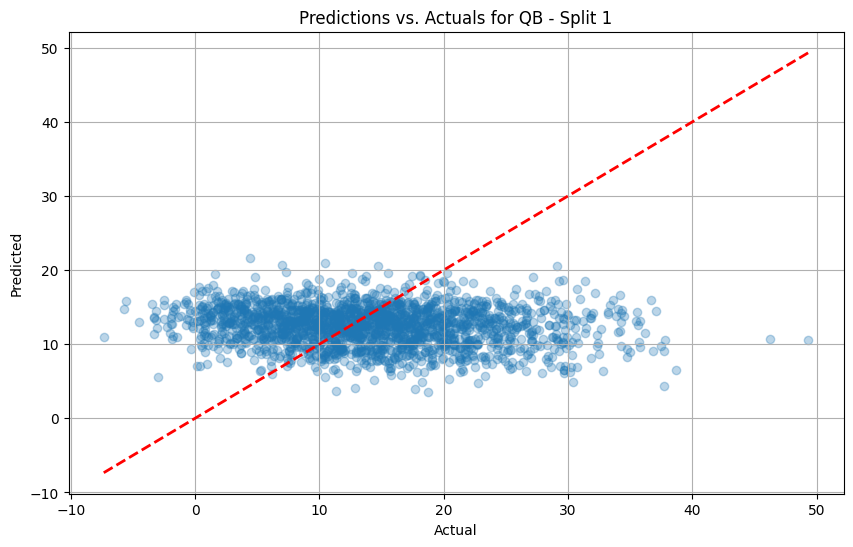

Mean Squared Error (MSE): 83.88766775382655
Mean Absolute Error (MAE): 7.2825361112248705
R² Score: -0.23977279852413802
Evaluating RNN model for qb - split 2...


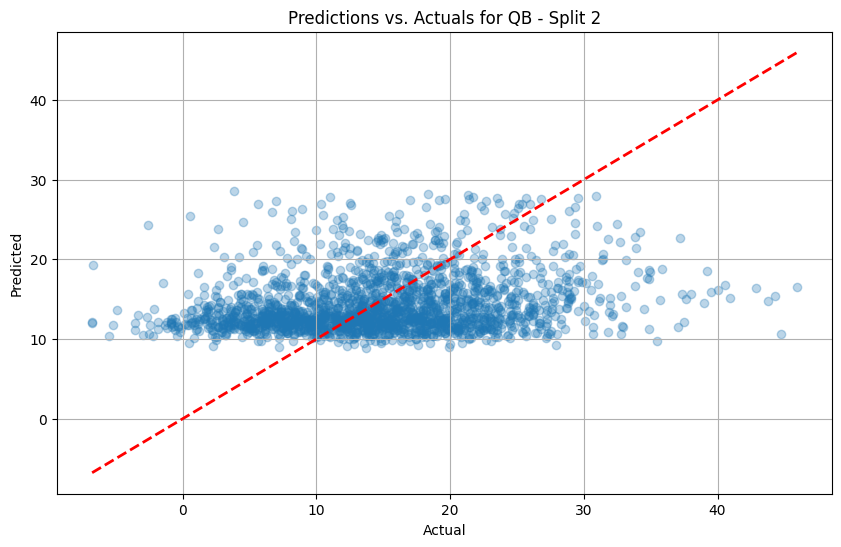

Mean Squared Error (MSE): 63.40084619732987
Mean Absolute Error (MAE): 6.304339773029578
R² Score: -0.005233744200016099
Evaluating RNN model for qb - split 3...


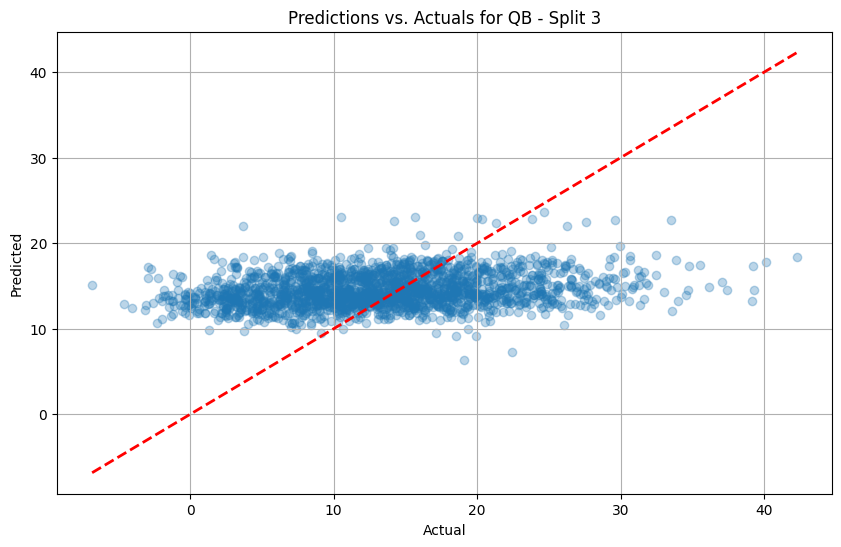

Mean Squared Error (MSE): 54.701009299855215
Mean Absolute Error (MAE): 5.9466056336535775
R² Score: 0.02694144612418703
Evaluating RNN model for qb - split 4...


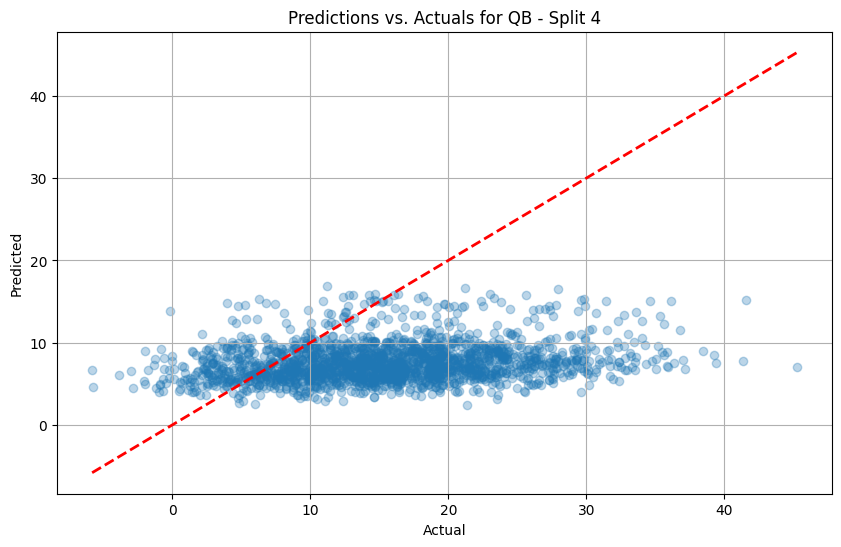

Mean Squared Error (MSE): 119.52511214899539
Mean Absolute Error (MAE): 8.88680279306701
R² Score: -0.9857711429166596
Evaluating RNN model for qb - split 5...


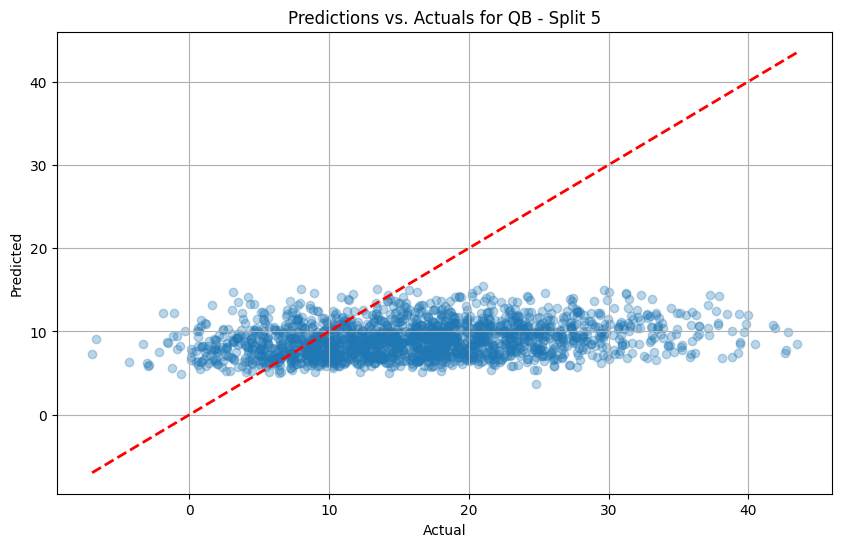

Mean Squared Error (MSE): 118.31828995436396
Mean Absolute Error (MAE): 8.638472019517032
R² Score: -0.65542074628019
Evaluating RNN model for rb - split 1...


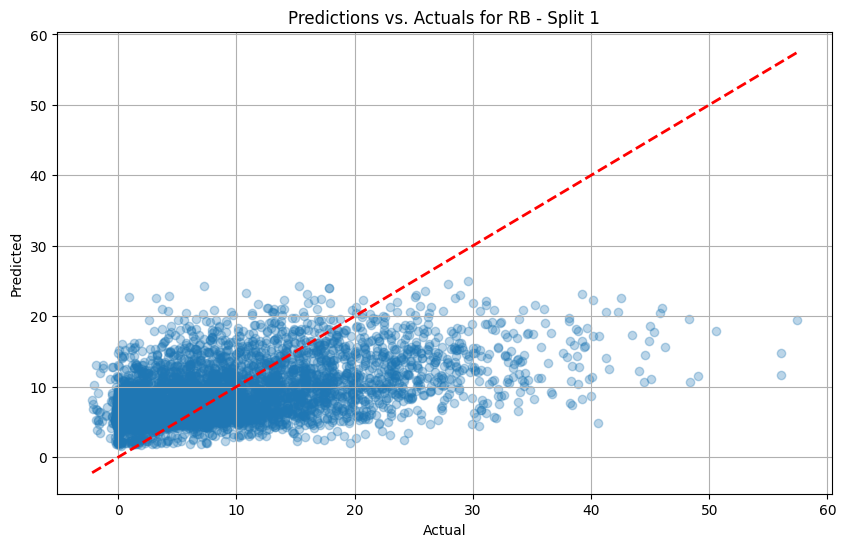

Mean Squared Error (MSE): 47.01750366078401
Mean Absolute Error (MAE): 5.204080383468328
R² Score: 0.3004253912571053
Evaluating RNN model for rb - split 2...


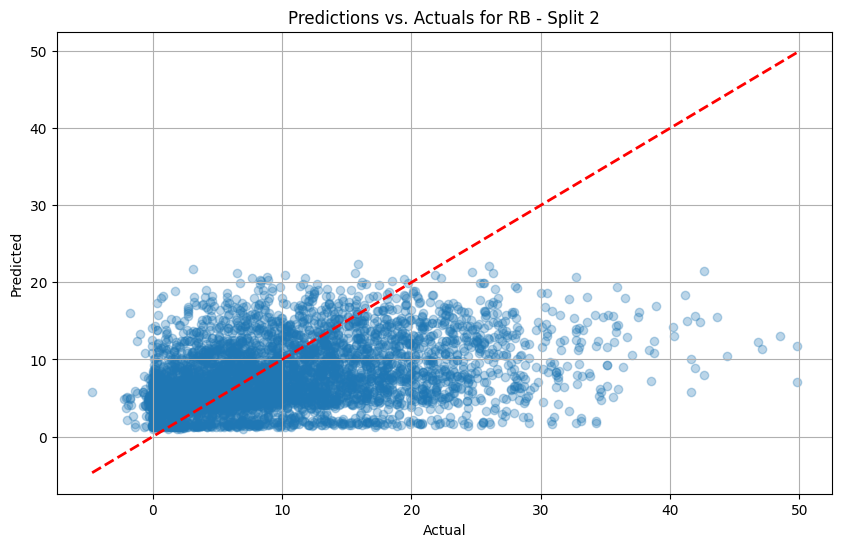

Mean Squared Error (MSE): 52.175879701651525
Mean Absolute Error (MAE): 5.208654392892409
R² Score: 0.17084279319800255
Evaluating RNN model for rb - split 3...


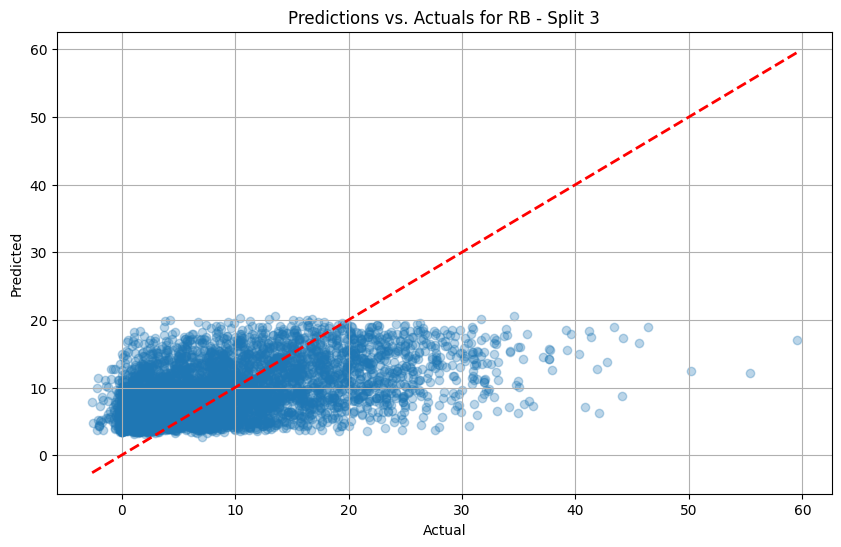

Mean Squared Error (MSE): 42.261713796629145
Mean Absolute Error (MAE): 4.995656594731195
R² Score: 0.30180747059655033
Evaluating RNN model for rb - split 4...


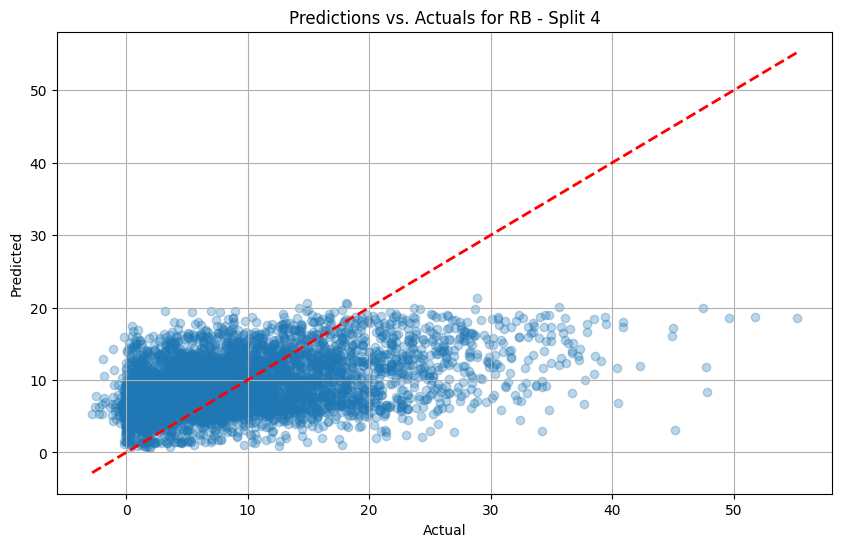

Mean Squared Error (MSE): 45.20170777997337
Mean Absolute Error (MAE): 5.214524607697631
R² Score: 0.23059721697594848
Evaluating RNN model for rb - split 5...


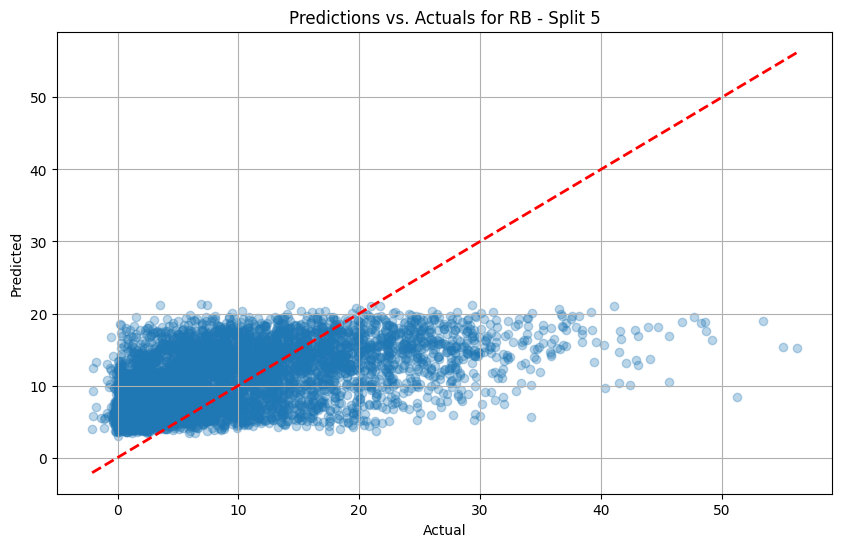

Mean Squared Error (MSE): 51.18586891306409
Mean Absolute Error (MAE): 5.693333302674113
R² Score: 0.2581684803198059
Evaluating RNN model for wr - split 1...


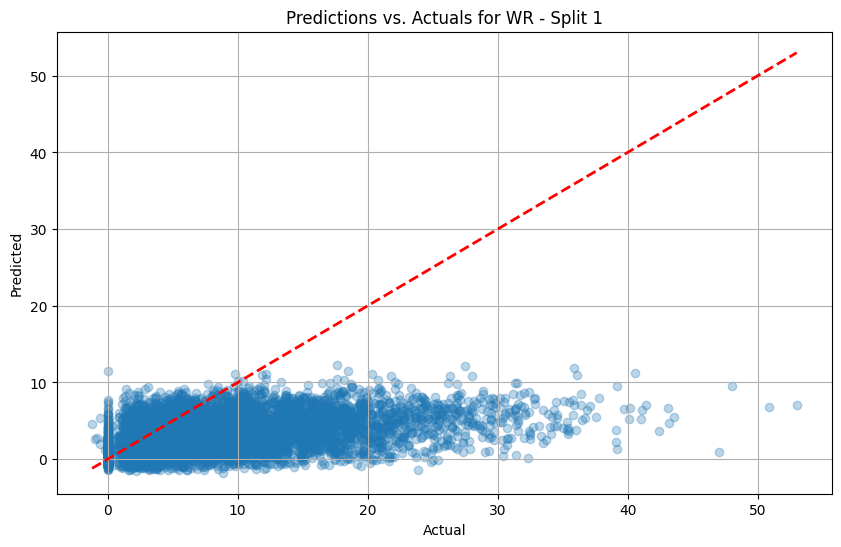

Mean Squared Error (MSE): 84.12129460756324
Mean Absolute Error (MAE): 6.498910091961534
R² Score: -0.42760065218657783
Evaluating RNN model for wr - split 2...


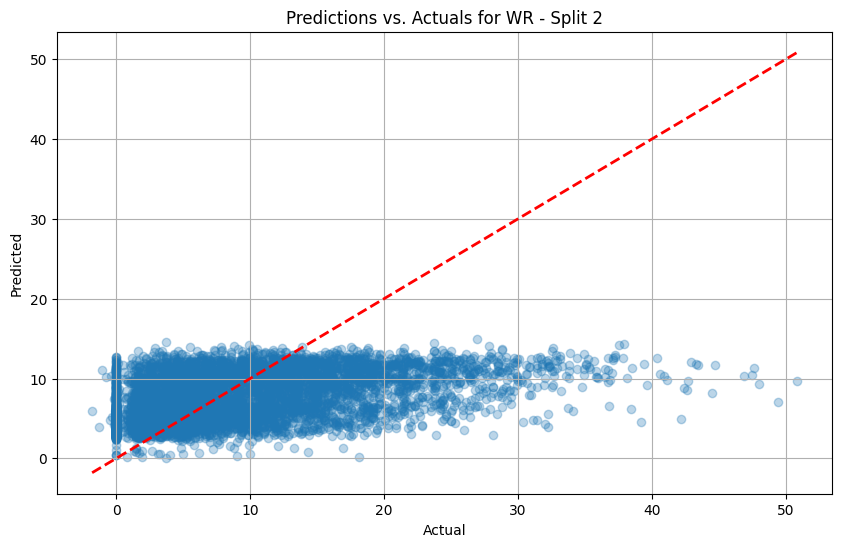

Mean Squared Error (MSE): 55.96610270689122
Mean Absolute Error (MAE): 5.538507151412746
R² Score: 0.13548746969907632
Evaluating RNN model for wr - split 3...


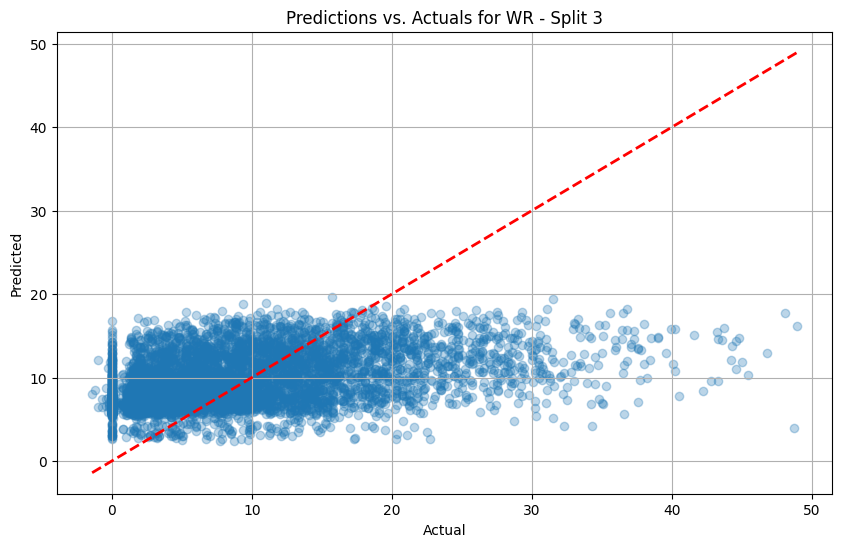

Mean Squared Error (MSE): 53.6825616147685
Mean Absolute Error (MAE): 5.701563425669117
R² Score: 0.17482763834513304
Evaluating RNN model for wr - split 4...


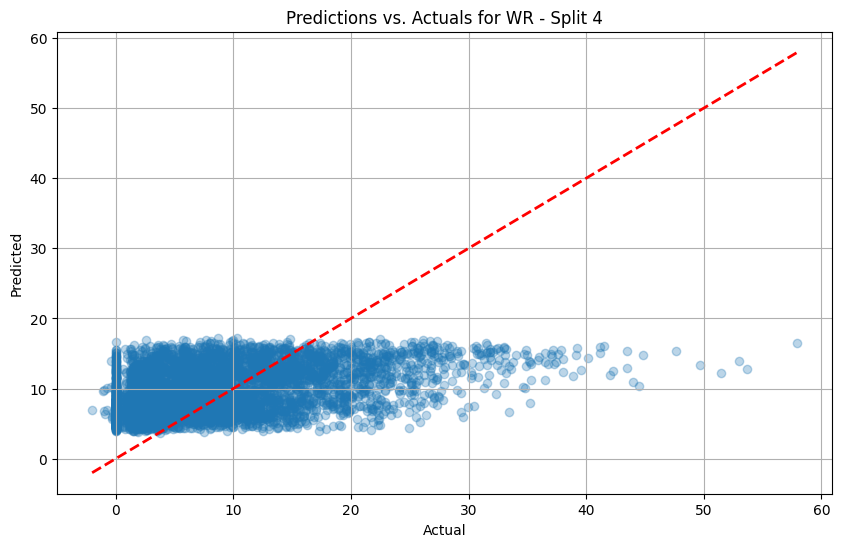

Mean Squared Error (MSE): 48.819344825633515
Mean Absolute Error (MAE): 5.581701258272612
R² Score: 0.1670085691586335
Evaluating RNN model for wr - split 5...


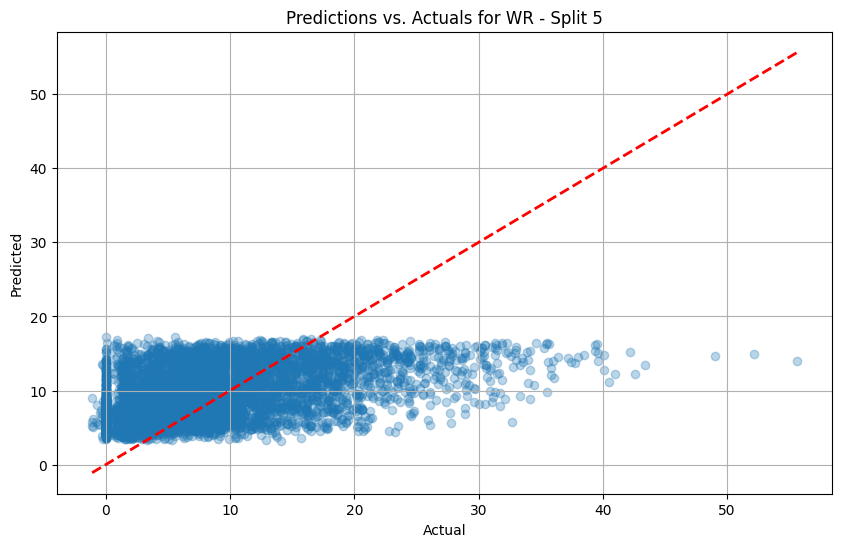

Mean Squared Error (MSE): 44.932577237944614
Mean Absolute Error (MAE): 5.351309956401179
R² Score: 0.19931457201860037
Evaluating RNN model for te - split 1...


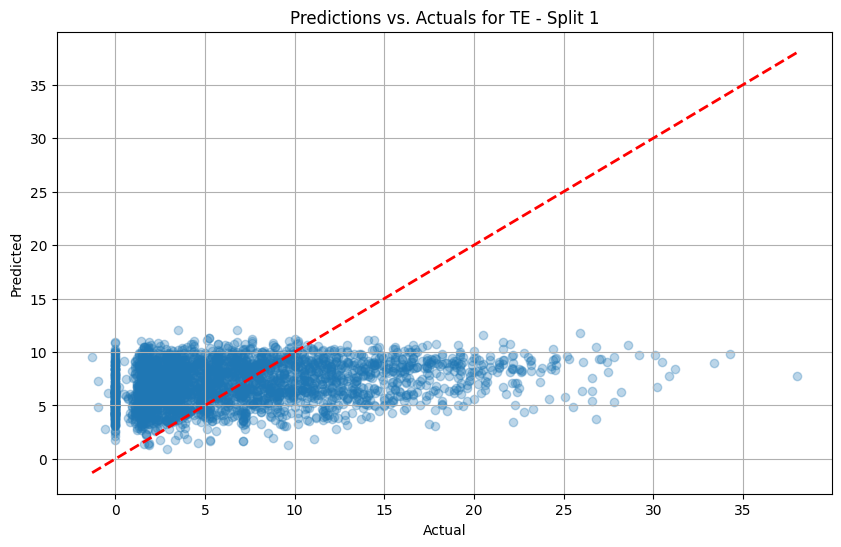

Mean Squared Error (MSE): 32.13394807972709
Mean Absolute Error (MAE): 4.490272414824736
R² Score: 0.06239455415011996
Evaluating RNN model for te - split 2...


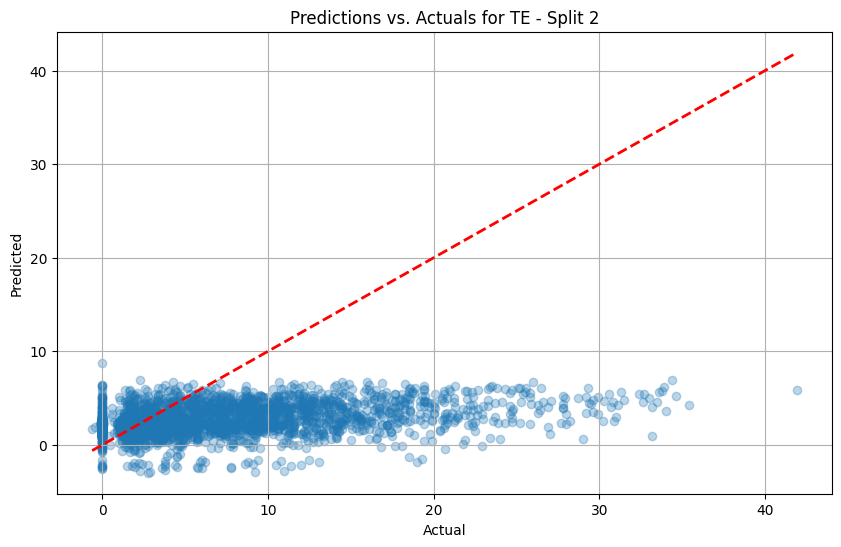

Mean Squared Error (MSE): 55.29866049701833
Mean Absolute Error (MAE): 4.937934639679212
R² Score: -0.25720145528745686
Evaluating RNN model for te - split 3...


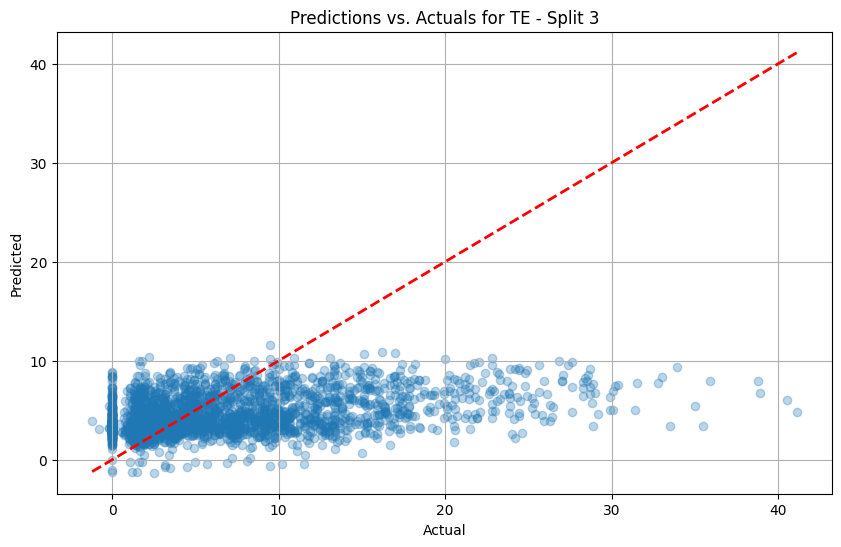

Mean Squared Error (MSE): 37.57570060572703
Mean Absolute Error (MAE): 4.131128925342818
R² Score: 0.07647762107079825
Evaluating RNN model for te - split 4...


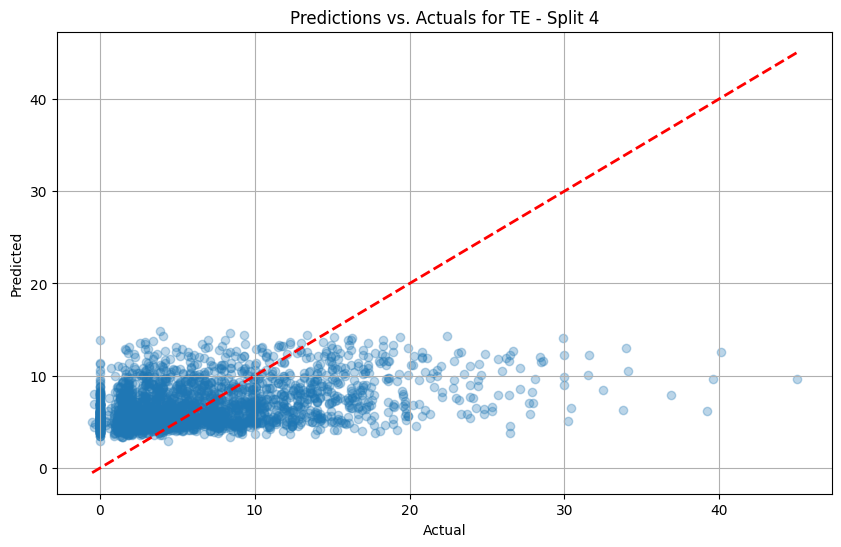

Mean Squared Error (MSE): 28.95179303566786
Mean Absolute Error (MAE): 4.154190619109161
R² Score: 0.16653813536756723
Evaluating RNN model for te - split 5...


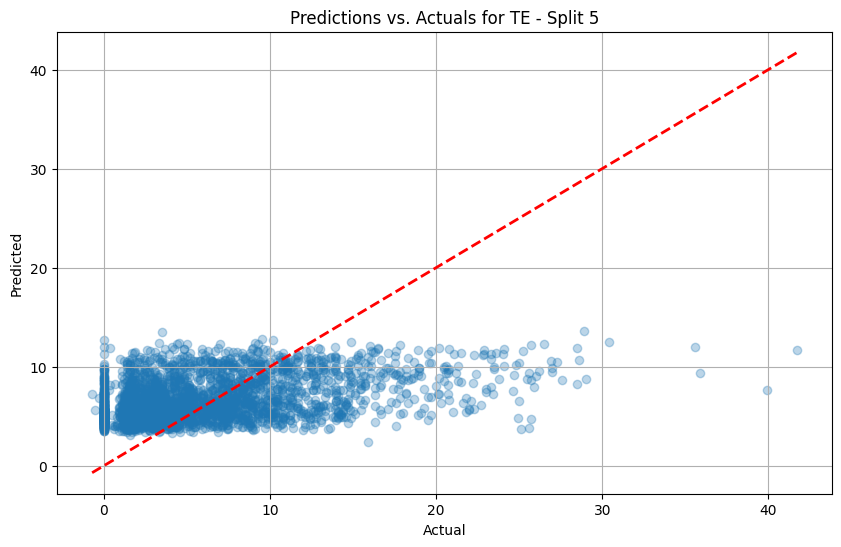

Mean Squared Error (MSE): 25.834096332799213
Mean Absolute Error (MAE): 3.982244144358407
R² Score: 0.14898364990474955
Mean Squared Error (MSE): 83.88766775382655
Mean Absolute Error (MAE): 7.2825361112248705
R² Score: -0.23977279852413802
Mean Squared Error (MSE): 63.40084619732987
Mean Absolute Error (MAE): 6.304339773029578
R² Score: -0.005233744200016099
Mean Squared Error (MSE): 54.701009299855215
Mean Absolute Error (MAE): 5.9466056336535775
R² Score: 0.02694144612418703
Mean Squared Error (MSE): 119.52511214899539
Mean Absolute Error (MAE): 8.88680279306701
R² Score: -0.9857711429166596
Mean Squared Error (MSE): 118.31828995436396
Mean Absolute Error (MAE): 8.638472019517032
R² Score: -0.65542074628019
Mean Squared Error (MSE): 47.01750366078401
Mean Absolute Error (MAE): 5.204080383468328
R² Score: 0.3004253912571053
Mean Squared Error (MSE): 52.175879701651525
Mean Absolute Error (MAE): 5.208654392892409
R² Score: 0.17084279319800255
Mean Squared Error (MSE): 42.2617137966291

/tmp/ipykernel_106637/2190060413.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  pl.legend()


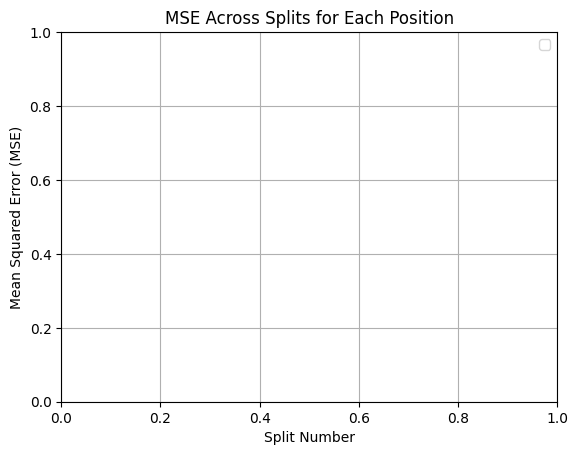

Mean Squared Error (MSE): 83.88766775382655
Mean Absolute Error (MAE): 7.2825361112248705
R² Score: -0.23977279852413802
Mean Squared Error (MSE): 63.40084619732987
Mean Absolute Error (MAE): 6.304339773029578
R² Score: -0.005233744200016099
Mean Squared Error (MSE): 54.701009299855215
Mean Absolute Error (MAE): 5.9466056336535775
R² Score: 0.02694144612418703
Mean Squared Error (MSE): 119.52511214899539
Mean Absolute Error (MAE): 8.88680279306701
R² Score: -0.9857711429166596
Mean Squared Error (MSE): 118.31828995436396
Mean Absolute Error (MAE): 8.638472019517032
R² Score: -0.65542074628019
Mean Squared Error (MSE): 47.01750366078401
Mean Absolute Error (MAE): 5.204080383468328
R² Score: 0.3004253912571053
Mean Squared Error (MSE): 52.175879701651525
Mean Absolute Error (MAE): 5.208654392892409
R² Score: 0.17084279319800255
Mean Squared Error (MSE): 42.261713796629145
Mean Absolute Error (MAE): 4.995656594731195
R² Score: 0.30180747059655033
Mean Squared Error (MSE): 45.2017077799733

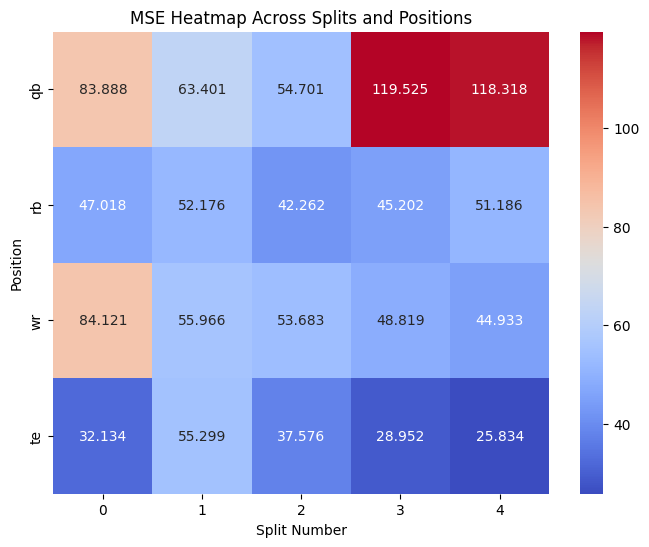

In [30]:
def plot_predictions(y_true, y_pred, key, split):
    pl.figure(figsize=(10, 6))
    pl.scatter(y_true, y_pred, alpha=0.3)
    pl.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    pl.xlabel('Actual')
    pl.ylabel('Predicted')
    pl.title(f'Predictions vs. Actuals for {key.upper()} - Split {split + 1}')
    pl.grid(True)
    pl.show()


def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R² Score: {r2}')
    return mse, mae, r2

for key, predictions in rnn_predictions_gru.items():
    for i, prediction in enumerate(predictions):
        dataset = normalized_datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        print(f"Evaluating RNN model for {key} - split {i + 1}...")
        
        # Plot Predictions vs. Actuals
        plot_predictions(y_true, y_pred, key, i)

        # Calculate and print evaluation metrics
        mse, mae, r2 = evaluate_predictions(y_true, y_pred)

        # Optionally, store the metrics for later comparison

evaluation_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, predictions in rnn_predictions_gru.items():
    for i, prediction in enumerate(predictions):
        dataset = normalized_datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        mse, mae, r2 = evaluate_predictions(y_true, y_pred)
        evaluation_results[key].append((mse, mae, r2))
        
pl.xlabel('Split Number')
pl.ylabel('Mean Squared Error (MSE)')
pl.title('MSE Across Splits for Each Position')
pl.legend()
pl.grid(True)
pl.show()

# Initialize the evaluation results dictionary
evaluation_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

# Evaluate predictions and store the MSE, MAE, R² score
for key, predictions in rnn_predictions_gru.items():
    for i, prediction in enumerate(predictions):
        dataset = normalized_datasets[key][i]
        y_true = dataset['y_test']
        y_pred = prediction

        mse, mae, r2 = evaluate_predictions(y_true, y_pred)
        evaluation_results[key].append(mse)  # Storing only MSE for heatmap

# Convert the evaluation results into a DataFrame for heatmap plotting
import pandas as pd

# Convert evaluation results to a DataFrame
heatmap_data = pd.DataFrame(evaluation_results)

# Plot the heatmap
pl.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, annot=True, cmap='coolwarm', fmt=".3f", cbar=True)

pl.xlabel('Split Number')
pl.ylabel('Position')
pl.title('MSE Heatmap Across Splits and Positions')
pl.show()


In [31]:
def compute_permutation_importance(model, X_test, y_test, n_repeats=5):
    baseline_mse = mean_squared_error(y_test, model.predict(X_test))
    importances = np.zeros(X_test.shape[1])

    for i in range(X_test.shape[1]):
        shuffled_mses = []
        for _ in range(n_repeats):
            X_test_permuted = X_test.copy()
            np.random.shuffle(X_test_permuted[:, i])
            shuffled_mses.append(mean_squared_error(y_test, model.predict(X_test_permuted)))
        
        importances[i] = np.mean(shuffled_mses) - baseline_mse

    return importances

# Compute permutation feature importance for each model and each split
feature_importance_results = {
    'qb': [],
    'rb': [],
    'wr': [],
    'te': []
}

for key, models in rnn_models_gru.items():
    for i, model in enumerate(models):
        dataset = normalized_datasets[key][i]
        X_test = dataset['X_test']
        y_test = dataset['y_test']

        print(f"Computing feature importance for {key} - split {i + 1}...")
        importances = compute_permutation_importance(model, X_test, y_test)
        feature_importance_results[key].append(importances)

# Convert feature importance results to DataFrame
import pandas as pd

# Assuming all splits have the same number of features, create a DataFrame
feature_names = [f'Feature_{j}' for j in range(X_test.shape[1])]
importance_df = pd.DataFrame(np.mean(np.array([np.array(importance).T for importance in feature_importance_results[key]]), axis=0),
                             columns=feature_names)

# Plot the feature importances as a heatmap
pl.figure(figsize=(12, 8))
sns.heatmap(importance_df, annot=True, cmap='viridis', fmt=".3f", cbar=True)

pl.xlabel('Features')
pl.ylabel('Position')
pl.title('Permutation Feature Importance Heatmap')
pl.show()

Computing feature importance for qb - split 1...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Computing feature importance for qb - split 2...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
61/61 

ValueError: Shape of passed values is (3, 1), indices imply (3, 3)